## IMPORT DATASET

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel('talep_data.xlsx', 'data', parse_dates=True, index_col='TARIH')

## PRE-PROCESSING

In [3]:
# Drop all the features except sales 
df.drop(['URUN_ID', 'URUN_GRUBU', 'STOK_DISI_SURE'], axis=1, inplace=True)

In [4]:
df.head()

,SATIS_ADET
TARIH,
2017-01-01,2784.0
2017-01-02,10484.0
2017-01-03,8934.0
2017-01-04,10185.0
2017-01-05,13850.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1032 entries, 2017-01-01 to 2019-11-30
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SATIS_ADET  1031 non-null   float64
dtypes: float64(1)
memory usage: 16.1 KB


In [6]:
# Check for missing points
df.isnull().sum()

SATIS_ADET    1
dtype: int64

*  There is one missing sales value of 2019-04-20.
*  And also sale of 2018-12-28 is zero.
*  So drop them.

In [7]:
# Drop the missing row of 2019-04-20
df = df.drop(df[df.index == '2019-04-20'].index)

In [8]:
# Drop the row of 2018-12-28 which has sales value of zero
df = df.drop(df[df.index == '2018-12-28'].index)

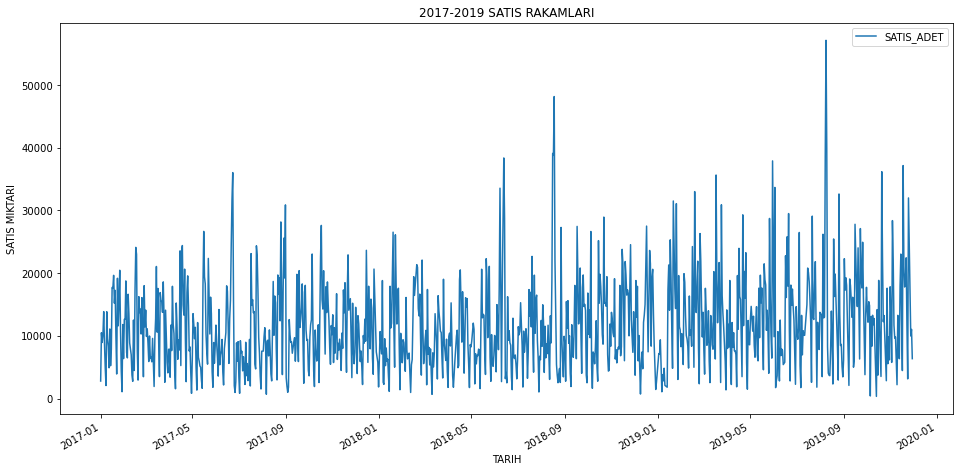

In [9]:
# Visualize the whole dataset
df.plot(figsize=(16,8))
plt.title('2017-2019 SATIS RAKAMLARI')
plt.xlabel('TARIH')
plt.ylabel('SATIS MIKTARI')
plt.show()

## CREATE FEATURES

In [10]:
# New features are created from the timestamps
df['YIL'] = df.index.year
df['AY'] = df.index.month
df['HAFTA'] = df.index.isocalendar().week.astype(int)
df['GUN'] = df.index.day
df['HAFTANIN_GUNU'] = df.index.dayofweek
df['HAFTASONU'] = df['HAFTANIN_GUNU'].isin([5, 6]).astype(int)

In [11]:
df.head()

,SATIS_ADET,YIL,AY,HAFTA,GUN,HAFTANIN_GUNU,HAFTASONU
TARIH,,,,,,,
2017-01-01,2784.0,2017,1,52,1,6,1
2017-01-02,10484.0,2017,1,1,2,0,0
2017-01-03,8934.0,2017,1,1,3,1,0
2017-01-04,10185.0,2017,1,1,4,2,0
2017-01-05,13850.0,2017,1,1,5,3,0


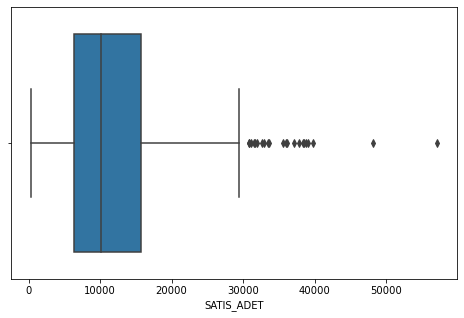

In [12]:
# Boxplot of the sales
plt.figure(figsize=(8,5))
sns.boxplot(x=df['SATIS_ADET'])
plt.show()

*  There are some outliers but since the machine learning models that I use are robust to outliers, I keep them.

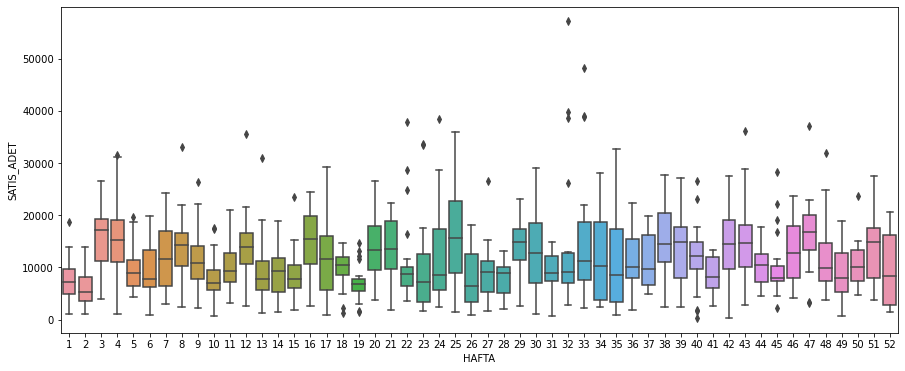

In [13]:
plt.figure(figsize=(15,6))
sns.boxplot(x=df['HAFTA'], y=df['SATIS_ADET'])
plt.show()

*  **Observation:** There seems to be some seasonality in sales.

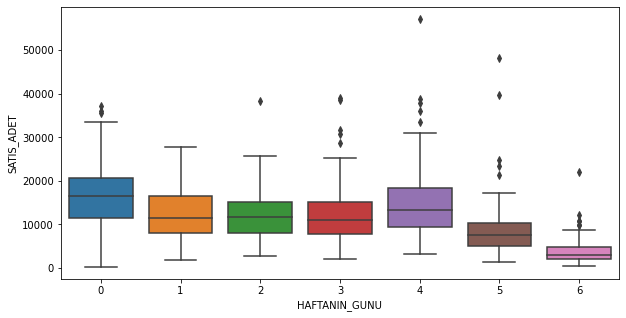

In [14]:
plt.figure(figsize=(10,5))
sns.boxplot(x=df['HAFTANIN_GUNU'], y=df['SATIS_ADET'])
plt.show()

*  **Observation:** The sales are relatively low on weekends (5,6) (especially on sundays) 

### Train - Validation Split

In [15]:
X = df.drop('SATIS_ADET', axis=1)
y = df['SATIS_ADET']

In [16]:
# Choose the last month (November 2019) as validation set, all remaining as training set
X_train = X[:-29]
y_train = y[:-29]
X_val = X[-29:]
y_val = y[-29:]

## MODELING - EVALUATION

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [18]:
# This function takes the model and prints the evaluation results
def evaluate_model(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    results = pd.concat([y_val, pd.Series(pred, index=y_val.index, name='TAHMIN')], axis=1)
    results.plot(figsize=(8,5))
    plt.show()
    rmse_score = mean_squared_error(y_val, pred, squared=False)
    print(f'RMSE Score: {rmse_score}')

#### RANDOM FOREST

In [19]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100,
                            random_state=123)

In [20]:
# Hyperparameter Tuning for Random Forest
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [16, 18, 20],
}

#grid = GridSearchCV(rf, params, scoring='neg_root_mean_squared_error')
#grid.fit(X_train, y_train)

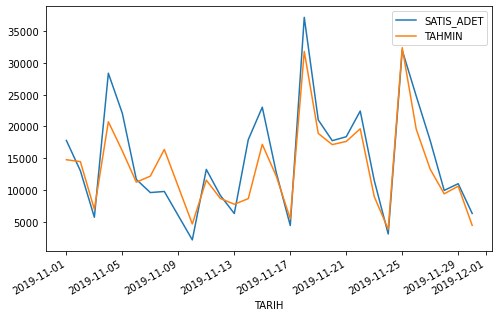

RMSE Score: 3661.8363995362993


In [21]:
evaluate_model(rf)

#### XGBOOST

In [22]:
from xgboost import XGBRegressor
xgb = XGBRegressor(
        n_estimators=200,
        max_depth=5,
        nthread=-1,
        seed=123)

In [23]:
# Hyperparameter Tuning for XGBoost
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'subsample': [0.4, 0.7, 1],
    'colsample_bytree': [0.4, 0.7, 1]
}

#grid = GridSearchCV(xgb, params, scoring='neg_root_mean_squared_error')
#grid.fit(X_train, y_train)

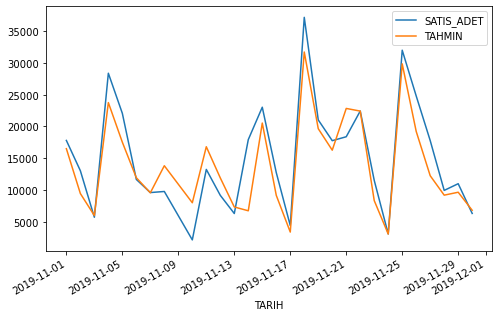

RMSE Score: 3736.3199275137736


In [24]:
evaluate_model(xgb)

#### LGBM

In [25]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(
            n_estimators=200,
            num_leaves=9,
            random_state=123,
            verbose=-1)

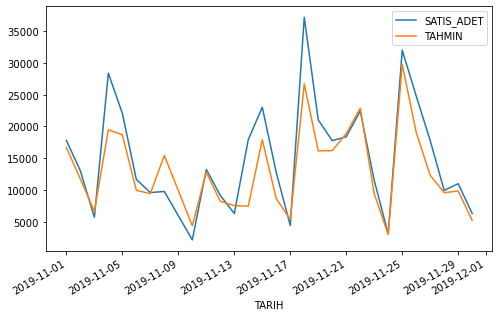

RMSE Score: 4145.175127977067


In [26]:
evaluate_model(lgbm)

*  **RESULT:** Based on the evaluation metric results of the 3 model, I choose the Random Forest.

## MAKE PREDICTION

In [27]:
# Train the model again but this time with the whole dataset
X_train = X
y_train = y

In [28]:
# Create the test-set features
X_test = pd.DataFrame(index=pd.date_range('2019-12-01', '2019-12-31'))

X_test['YIL'] = X_test.index.year
X_test['AY'] = X_test.index.month
X_test['HAFTA'] = X_test.index.isocalendar().week.astype(int)
X_test['GUN'] = X_test.index.day
X_test['HAFTANIN_GUNU'] = X_test.index.dayofweek
X_test['HAFTASONU'] = X_test['HAFTANIN_GUNU'].isin([5, 6]).astype(int)

In [29]:
X_test.head()

,YIL,AY,HAFTA,GUN,HAFTANIN_GUNU,HAFTASONU
2019-12-01,2019,12,48,1,6,1
2019-12-02,2019,12,49,2,0,0
2019-12-03,2019,12,49,3,1,0
2019-12-04,2019,12,49,4,2,0
2019-12-05,2019,12,49,5,3,0


In [30]:
# Make predictions with selected model (Random forest)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
pred = np.round(pred)

In [31]:
# Create a dataframe from the predictions
pred_df = pd.DataFrame(pred, index=pd.date_range('2019-12-01', '2019-12-31'), columns=['TALEP TAHMIN'])
pred_df.head()

,TALEP TAHMIN
2019-12-01,4670.0
2019-12-02,22412.0
2019-12-03,17996.0
2019-12-04,17485.0
2019-12-05,19027.0


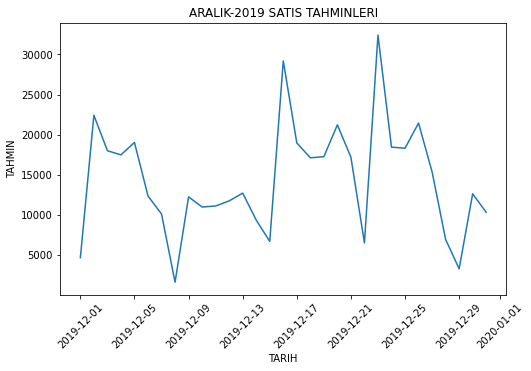

In [32]:
# Visualize the predictions
plt.figure(figsize=(8,5))
plt.plot(pred_df)
plt.xticks(rotation=45)
plt.title('ARALIK-2019 SATIS TAHMINLERI')
plt.xlabel('TARIH')
plt.ylabel('TAHMIN')
plt.show()

#### SUBMIT PREDICTIONS TO EXCEL FILE

In [33]:
pred_df['TARIH'] = pred_df.index.date
pred_df = pred_df[['TARIH', 'TALEP TAHMIN']]
pred_df.to_excel('tahmin_aralik_2019.xlsx', index=False)